# Forecast Window 

Let's put our best performing model to the test: we'll have a day's worth of predictions and ask the network to make a forecast on the time series then 

In [4]:
import tensorflow as tf 
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns 

import numpy as np
from scipy import stats

import os

difference = 0.0

# Some useful functions

# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data(x):
    minX = np.min(x[np.nonzero(x)])
    maxX = np.max(x[np.nonzero(x)])
    normed = (x - minX)/(maxX - minX)
    
    # Zero out any values that are above 1
    normed[normed>1] =  0
    
    return normed, minX, maxX

# Routine to ... UNNORMALIZE. This is done to convert the data back to the original time scale. 

def unnorm_data(x, minX, maxX):
    unnorm_fac = (maxX - minX)
    print(unnorm_fac)
    return x*unnorm_fac + minX
    
# This applies a rolling average on the dataset 

# Function taken from a learnpython article

def roll_average(input_data, window_size):
    result = []
    for i in range(len(input_data) - window_size + 1):
        window = input_data[i:i+window_size]
        window_average = sum(window)/window_size
        result.append(window_average)
        
    return np.array(result)
    
def rollify_training(X, window_size):
    X_features = X.shape[2]
    
    X_roll_len = X.shape[1] - window_size + 1
    
    X_roll = np.empty((len(X), X_roll_len, X_features))
    
    for ii in range(len(X)):
        for jj in range(X_features):
            X_roll[ii,:,jj] = roll_average(X[ii,:,jj], window_size)
            
    return X_roll

# This function batches up consecutive pieces of data


def batch_consecutive(direc_name, iterate=1):
    directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    
    prev_int = int(os.path.splitext(directory_list[0])[0])
    total_batches = []
    consecutive_batch = []
    
    for jj, name in enumerate(directory_list):
        name_int = int(os.path.splitext(name)[0])
        if (name_int-prev_int==iterate) or (name_int-prev_int==0):
            consecutive_batch.append(name)
            prev_int = name_int

        elif(name_int-prev_int>iterate):
            total_batches.append(consecutive_batch)
            consecutive_batch = []
            consecutive_batch.append(name)
            prev_int = name_int
        
    total_batches.append(consecutive_batch)
    return total_batches

    
def mse_mod(y_true, y_pred):

    loss = K.mean(K.square(y_pred - y_true), axis=-1)
    loss_true = tf.reduce_mean(loss)
    
    # We add a small epsillion to the MSE. This makes it so that we avoid crazy losses
    return loss_true + 1e-8


In [5]:
# Routine to normalize between 0 and 1 (Following the atmospheric turbulence paper)

def norm_data_select(x, minX, maxX):  
    normed = (x - minX)/(maxX - minX)
    
    # Zero out any values that are above 1
    
    normed[normed>1] =  0
    
    return normed, minX, maxX


def load_data(total_batches, time_steps, input_list, window_size, num_of_examples, minOut_X, maxOut_X, full_time_series=False, pad_output_zeros = True,  forecast_len=1, time_res=1, start_index=0):

    total_input = []
    total_output = []
    
    print(f'Parameter List: {input_list}')
    
    num_of_zeros = 0
    num_features = len(input_list)
    
    
    for jj, name in enumerate(total_batches, start=start_index):
        
        df = pd.read_csv(f'{direc_name}/{name}')
        print(name)
        #print(name)
        # rename columns to something more decipherable 
        df = df.rename(columns={'Temp °C':'temperature', 'RH %':'relative_humidity', 'kJ/m^2':'solar_radiation'})
        #print(df.columns)
        #input()
        
        # If the prior/future CN2 columns have zero values, then continue to next iteration 
        if(df['CN2']==0).any() or (df['CN2 Future']==0).any():
            #print(jj)
            num_of_zeros += 1
            print(f'number of zeros: {num_of_zeros}')
            print('error data detected. Skipping to next value')
            continue
        
        dataset_weather = np.empty((time_steps, num_features))
        dataset_output = np.empty((output_len, 1))
        
        ###### INPUT DATA #######
        
        for ii, colName in enumerate(input_list):
            if(colName=='CN2'):
                dataset_weather[:,ii] = np.log10(df[colName][:].to_numpy())
            else:
                dataset_weather[:,ii] = df[colName][:].to_numpy()
                
        ###### OUTPUT DATA #######
        
        # In the 0th output, CN2 FUTURE
        
        # First, let's consider every example up to forecast length 
        nn_output  = np.log10(df["CN2 Future"][:forecast_len].to_numpy())
        
        # Next, only consider every time_res example in the final output
        dataset_output[:,0] = nn_output[np.mod(np.arange(len(nn_output)),time_res) == 0]
        
        # Let's consider wildly varying output data. Compute the difference between maximum and minimum. 
        max_CN2 = np.max(np.abs(dataset_output[:,0]))
        min_CN2 = np.min(np.abs(dataset_output[:,0]))
        
        diff = np.abs(max_CN2 - min_CN2)
        
        if (diff >= -1):
            total_input.append(dataset_weather)
            total_output.append(dataset_output)
            
        if (jj%500==0):
            print(f"Data loaded:{jj}")
            
        if (jj-start_index>num_of_examples):
            print("Finished loading data!")
            break;
                
    total_input = np.array(total_input)
    total_output = np.array(total_output)
    
    # Apply rolling average onto the input data
    total_input = rollify_training(total_input, window_size)
    
    # Apply normalization to each input entry (except for CN2, this needs to be handled specially)
    for ii in (np.arange(len(input_list)-1)):
        #print(ii)
       # total_input[:,:,ii], minOut,maxOut = norm_data(total_input[:,:,ii])
        # print(minOut)
        # print(maxOut)
        
        total_input[:,:,ii],_,_ = norm_data_select(total_input[:,:,ii], minOut_X[ii], maxOut_X[ii])

    # If we are working with time series prediction, apply rolling on output time series
    
    if (full_time_series):
        total_output = rollify_training(total_output, window_size)
    
    # Finally, if we're working with a time series, let's pad out the output array with 0s
    
    window_time_steps_input = total_input.shape[1]
    window_time_steps_output = total_output.shape[1]
    dataset_len = int(total_input.shape[0])

    total_output_padded = np.zeros((total_input.shape[0], window_time_steps_input, 1))

    total_output_padded[:,:window_time_steps_output, 0] = total_output[:,:,0]

    # At this point, normalize the CN2 for BOTH input and output. This is important!
    
    ziggy = np.concatenate((total_input[:,:,3], total_output_padded[:,:,0]))
    ziggy, minOut, maxOut = norm_data_select(ziggy, minOut_X[3], maxOut_X[3])
    

    total_input[0:dataset_len,:,3] = ziggy[0:dataset_len, :]
    total_output_padded[0:dataset_len,:,0] = ziggy[dataset_len::,:]
    
    if(full_time_series):
        if (pad_output_zeros==False):
            total_output[:,:,0] = total_output_padded[:,0:output_len,0]
            return total_input, total_output, minOut, maxOut
        return total_input, total_output_padded, minOut, maxOut 
    else:
        return total_input, total_output_padded[:,0], minOut, maxOut
    
    

# New Data Loader Function

In [6]:
def hours_to_int(x):
    if x[0:-2]=='':
        return 0
    else:
        return int(x[0:-2])
    
def convert_to_sec(minute, hour):
    return 3600*hour + 60*minute


def load_data(total_batches, direc_name, time_steps, input_list, window_size, num_of_examples, full_time_series=False, pad_output_zeros = True,  forecast_len=1, time_res=1, start_index=0):

    total_input = []
    total_output = []
    
    # Files expected
    
    #directory_list = [name for name in os.listdir(f'{direc_name}/.')]
    
    num_features = len(input_list)
    print(num_features)
    if ('day' in input_list):
        num_features+= 1
    if ('time' in input_list):
        num_features+= 1
    
    print(f'Parameter List: {input_list}')
    print(f'Number of Examples: {num_of_examples}')
    
    num_of_zeros = 0
    
    for jj, name in enumerate(total_batches, start=start_index):
        
        print(jj)
        
        if (jj>num_of_examples):
            print("Finished loading data!")
            break;
        
        df = pd.read_csv(f'{direc_name}/{name}')
        print(name)
        # rename columns to something more decipherable 
        df = df.rename(columns={'Temp °C':'temperature', 'RH %':'relative_humidity', 'kJ/m^2':'solar_radiation', 'Wind Speed m/s':'wind_speed', 'SOG cm':'SOG','Pressure hPa':'pressure', 'hr:min (UTC)':'time', 'Julian day (UTC)': 'day'})
        # Map the day into a unit circle, and create 'day_sin'  and 'day_cos' to define the x and y components in the circle. 
        df['day_sin'] = np.sin(df['day']*(2.*np.pi/365))
        df['day_cos'] = np.cos(df['day']*(2.*np.pi/365))
        # For time, we convert to string representation
        df['time']=df['time'].astype(str)
        df['minute'] = df['time'].apply(lambda x: int(x[-2:]))
        df['hour'] = df['time'].apply(lambda x: hours_to_int(x))
        df['second'] = convert_to_sec(df['minute'], df['hour'])
        # Map the time into a unit circle 
        df['time_sin']= np.sin(df['second']*(2.*np.pi/86400))
        df['time_cos']= np.cos(df['second']*(2.*np.pi/86400))

        #print(df.columns)
        #input()
        
        # If the prior/future CN2 columns have zero values, then continue to next iteration 
        if(df['CN2']==0).any() or (df['CN2 Future']==0).any():
             #print(jj)
             num_of_zeros += 1
             print(f'number of zeros: {num_of_zeros}')
             print('error data detected. Skipping to next value')
             continue
        
        dataset_weather = np.empty((time_steps, num_features))
        dataset_output = np.empty((output_len, 1))
        
        ###### INPUT DATA #######
        ii= 0
        kk= 0 # index for column
        
        while ii < num_features:
           # print(ii)
            colName = input_list[kk]
            if(colName=='day'):
             
                # include both day_sin and day_cos
                
                dataset_weather[:,ii] = df['day_sin'].to_numpy()
                ii += 1
                dataset_weather[:,ii] = df['day_cos'].to_numpy()
                
            elif(colName=='time'):
                
                # Include both time_sin and time_cos
                
                dataset_weather[:,ii] = df['time_sin'].to_numpy()
                ii += 1
                dataset_weather[:,ii] = df['time_cos'].to_numpy()
               
                
            elif(colName=='CN2'):
                dataset_weather[:,ii] = np.log10(df[colName].to_numpy())
            else:
                
                dataset_weather[:,ii] = df[colName].to_numpy()
            kk += 1
            ii += 1
                
        ###### OUTPUT DATA #######
        
        # In the 0th output, CN2 FUTURE
        
        # First, let's consider every example up to forecast length 
        nn_output  = np.log10(df["CN2 Future"][:forecast_len].to_numpy())
        
        # Next, only consider every time_res example in the final output
        dataset_output[:,0] = nn_output[np.mod(np.arange(len(nn_output)),time_res) == 0]
        
        # Let's consider wildly varying output data. Compute the difference between maximum and minimum. 
        max_CN2 = np.max(np.abs(dataset_output[:,0]))
        min_CN2 = np.min(np.abs(dataset_output[:,0]))
        diff = np.abs(max_CN2 - min_CN2)
        
        if (diff >= -1):
            total_input.append(dataset_weather)
            total_output.append(dataset_output)
            
        if (jj%500==0):
            print(f"Data loaded:{jj}")
                
    total_input = np.array(total_input)
    total_output = np.array(total_output)
    
    if(full_time_series):
        return total_input, total_output
    else:
        return total_input, total_output[:,0]

# Some tests

To begin, load the champion model

In [7]:
fifthteenMin_timeRes =  'trainSeries_15MinInput_6Hour_9487'

fifteenMin_fullNorm = 'trainSeries_15MinInput_6Hour_fullNorm_5621'
newNormOrder = 'trainSeries_newNormOrder_7379'
timeDay = 'trainSeries_timeDay_6154'
noOctober = 'trainSeries_noOctober_2759'
noOctober_timeDay = 'trainSeries_timeDay_noOctober_3121'
noOctober_full = 'trainSeries_timeDay_noOctober_full_9801'
noOctober_time = 'trainSeries_noOctober_time_3884'
full_time = 'trainSeries_24HourInput_time_1876'
full_time_revised = 'trainSeries_TimeDayNew_5481'

# fifthteenMin_timeRes = 'trainSeries_oneHourWindow_4Hour_5364'

loaded_model = tf.keras.models.load_model(f'models/{full_time_revised}', custom_objects={'mse_mod':mse_mod})

Load the data

In [16]:
input_features = ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
number_of_features = len(input_features)
if ('day' in input_features):
    number_of_features+= 1
if ('time' in input_features):
    number_of_features+= 1

# For consistency, normalize the data wrt training. This is for the 15 min, 6 hour res network w/ old norm

# minOut_X = [16.29781, -0.3995518, -16.46344155742847,  -18.04353]
# maxOut_X = [99.52488, 71.5599, -13.749579997691106,  32.07004]

# w/ new normalization

minOut = [16.29781, -0.3995518, -18.04353, -16.46344155742847]
maxOut_X = [99.52488, 71.5599,  32.07004, -13.749579997691106]

# w/ new normalization (including day/time)

minTrain = [16.29781, -0.3995518, -18.04353,  -1.0, -1.0, -16.46344155742847]
maxTrain = [99.52488, 71.5599, 32.07004, 1.0, 1.0, -13.749579997691106]

# w/ new normalization (w/o october unseen data)

#minTrain = [16.29781, -0.3995518, -18.04353, -16.46344155742847]
#maxTrain = [99.52488, 71.5599, 32.07004, -13.749579997691106]
 
time_len = 720
time_res = 15
forecast_len = 360
output_len = int(forecast_len/time_res)

batch_index = 1

# (total_batches, time_steps, input_list, window_size, num_of_examples, full_time_series=False, pad_output_zeros = True,  forecast_len=1, time_res=1)

direc_name = f"Batched Data/FebMar_Unseen" # yaml worthy
direc_name_raw = f"Batched Data/FebMarch_Unseen_RAW"
total_batches = batch_consecutive(direc_name, 1)
total_batches_raw = batch_consecutive(direc_name_raw, 1)

In [17]:
X = []
y = []
y_raw = []
X_raw = []
x_minor_ticks = [] 
count_init = 0
start_index =  0
end_index = 100

for ii in range(0, len(total_batches)):
    X_temp, y_temp = load_data(total_batches[ii], direc_name, time_len, input_features, 1, end_index, full_time_series=True, forecast_len=forecast_len, time_res=time_res, start_index=start_index)
    X_raw_temp, y_raw_temp = load_data(total_batches[ii], direc_name_raw, time_len, input_features, 1, end_index, full_time_series=True, forecast_len=forecast_len, time_res=time_res, start_index=start_index)
    
    temp = np.shape(y_temp.flatten())[0]/4
    #print(np.shape(y_temp.flatten())[0]/4)
    count_init += int(temp)
    x_minor_ticks.append(count_init)
    X.append(X_temp)
    y.append(y_temp)
    y_raw.append(y_raw_temp)
    X_raw.append(X_raw_temp)

    
#X = np.array(X)
#y = np.array(y)
#y_raw = np.array(y_raw)

5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 100
0
00000840.csv
Data loaded:0
1
00000841.csv
5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 100
0
00000840.csv
Data loaded:0
1
00000841.csv
5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 100
0
00000857.csv
Data loaded:0
1
00000858.csv
2
00000859.csv
3
00000860.csv
4
00000861.csv
5
00000862.csv
6
00000863.csv
7
00000864.csv
8
00000865.csv
9
00000866.csv
5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 100
0
00000857.csv
Data loaded:0
1
00000858.csv
2
00000859.csv
3
00000860.csv
4
00000861.csv
5
00000862.csv
6
00000863.csv
7
00000864.csv
8
00000865.csv
9
00000866.csv
5
Parameter List: ['relative_humidity', 'solar_radiation', 'temperature', 'time', 'CN2']
Number of Examples: 100
0
00000874.csv
Data

Alteranative: select a batch to plot

In [28]:

batch_start = -2
batch_end = -1

X = X[0,batch_start:batch_end,:,:]
y = y[0,batch_start:batch_end,:,:]
y_raw = y_raw[0,batch_start:batch_end,:,:]

TypeError: list indices must be integers or slices, not tuple

In [20]:
np.shape(y)

(58, 24, 1)

Use this is you want to plot all of the batches together

In [19]:
X = np.concatenate(X)
y = np.concatenate(y)

X_raw = np.concatenate(X_raw)
y_raw = np.concatenate(y_raw)

Normalize data 

In [21]:
# Normalize data 

for ii in np.arange(number_of_features):
        X[:,:,ii], _, _= norm_data_select(X[:,:,ii], minTrain[ii], maxTrain[ii])
        #X_test[:,:,ii],_,_ = norm_data_select(X_test[:,:,ii], minTrain[ii], maxTrain[ii])
        
        if (ii==number_of_features-1):
            y[:,:,0],_,_ = norm_data_select(y[:,:,0], minTrain[ii], maxTrain[ii])
            y_raw[:,:,0],_,_ = norm_data_select(y_raw[:,:,0], minTrain[ii], maxTrain[ii])
            #y_test[:,:,0],_,_ = norm_data_select(y_test[:,:,0], minTrain[ii], maxTrain[ii])


In [7]:
def min_to_hour(minute):
    return minute/60

hrs_2 = min_to_hour(np.arange(0,total_hours*15,15))

NameError: name 'total_hours' is not defined

Compute predictions from each loaded time series to create a predicted 12 hour time series 

In [22]:
def rms(y_true, y_pred):
    root_mean = np.sqrt((y_true - y_pred)**2)
    return root_mean 

forecasts = []

total_forecasts = np.array([])
y_total = np.array([])
y_raw_total = np.array([])

for ii in range(len(y)):
    munky = tf.expand_dims(X[ii,:,:], axis=0)
    preds = loaded_model.predict(munky, verbose=False)
    preds = np.array(preds[0]).flatten()
    
    total_forecasts = np.concatenate([total_forecasts, preds])
    y_total = np.concatenate((y_total,y[ii,:,0]))
    y_raw_total = np.concatenate((y_raw_total, y_raw[ii,:,0]))


ValueError: in user code:

    File "C:\Users\tjaou104\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2440, in predict_function  *
        return step_function(self, iterator)
    File "C:\Users\tjaou104\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2425, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\tjaou104\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2413, in run_step  **
        outputs = model.predict_step(data)
    File "C:\Users\tjaou104\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\training.py", line 2381, in predict_step
        return self(x, training=False)
    File "C:\Users\tjaou104\AppData\Local\anaconda3\Lib\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\tjaou104\AppData\Local\anaconda3\Lib\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "trainSeries_TimeDayNew_5481" is incompatible with the layer: expected shape=(None, None, 4), found shape=(None, 720, 6)


In [40]:
total_hours = len(total_forecasts)
foxy = rms(total_forecasts, y_raw_total)
#print(np.mean(foxy))

total_forecasts = 10**(unnorm_data(total_forecasts, minTrain[-1], maxTrain[-1]))

# total_forecast = np.concatenate((forecasts[0,:], forecasts[1,:], forecasts[2,:], forecasts[3,:], forecasts[4,:], forecasts[5,:]))
# y_total = np.concatenate((y[0,:,0], y[1,:,0], y[2,:,0], y[3,:,0], y[4,:,0], y[5,:,0]))

#foxy = rms(total_forecast, y_total)

2.7138615597373654


In [13]:
np.arange(0,total_hours*15,15)

array([    0,    15,    30, ..., 20835, 20850, 20865])

# IMPORTANT: PLEASE CHANGE NAME OF FIGURE 

In [57]:
396%6

0

In [58]:
fig_name='inset_October_5'
index_start = (396*4)
index_end = index_start + 24

Make the pretty plots

2.7138615597373654


C:\Users\tjaou104\AppData\Local\Temp\ipykernel_34436\1996404644.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(hrs_2[index_start:index_end], y_CN2[index_start:index_end], marker = 'd', facecolors='none', edgecolors=edgecolors[index_start:index_end], cmap='viridis_r', label='truth', s=36)


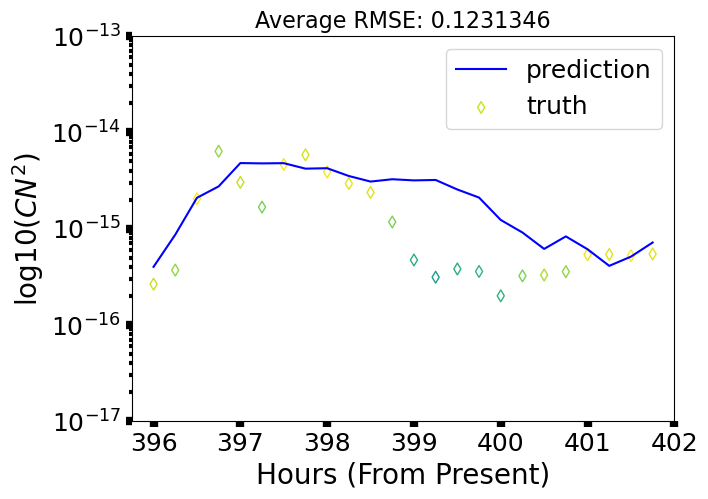

In [59]:
from matplotlib import cm

def min_to_hour(minute):
    return minute/60

hrs_2 = min_to_hour(np.arange(0,total_hours*15,15))
#hours = np.arange(total_hours)
y_CN2 = 10**(unnorm_data(y_raw_total, minTrain[-1], maxTrain[-1]))

cmap = plt.get_cmap('viridis_r')
norm_edge = plt.Normalize(min(foxy), max(foxy))
edgecolors = cmap(norm_edge(foxy))

plt.figure(figsize=(7,5))

#plt.figure(figsize=(25,5))

plt.plot(hrs_2[index_start:index_end], total_forecasts[index_start:index_end], color='blue', label = 'prediction')
plt.scatter(hrs_2[index_start:index_end], y_CN2[index_start:index_end], marker = 'd', facecolors='none', edgecolors=edgecolors[index_start:index_end], cmap='viridis_r', label='truth', s=36)

#  c = error_gradient[:time_len], cmap='viridis_r',

#plt.plot(hrs_2, truth[:output_len], 'd', mfc='none', markersize=12, label='truth')
#plt.plot(hrs_2, truth[:output_len], color='blue')

#cbar = plt.colorbar()
#cbar.set_ticks([0.0,1.0])
#cbar.ax.set_yticklabels([f'{round(np.max(foxy),7)}', f'{round(np.min(foxy),7)}' ], fontsize='18')
plt.ylabel(r'log10($CN^2$)', fontsize='20')
plt.xlabel('Hours (From Present)', fontsize='20')
plt.xticks(fontsize='18')
plt.xticks(x_minor_ticks, minor=True)
plt.yticks(fontsize='18')
plt.ylim(10**-17, 10**-13)
plt.xlim(-0.25+np.min(hrs_2[index_start:index_end]),np.max(hrs_2[index_start:index_end])+0.25)
plt.tick_params(which='major', width=6, length=4)
plt.tick_params(which='minor', width=3, length=2)
plt.yscale('log')
plt.title(f'Average RMSE: {round(np.mean(foxy[index_start:index_end]),7)}', fontsize='16')

plt.legend(fontsize='18')

plt.savefig(f'{fig_name}.pdf', format='pdf', bbox_inches='tight')

array([174.  , 174.25, 174.5 , 174.75, 175.  , 175.25, 175.5 , 175.75,
       176.  , 176.25, 176.5 , 176.75, 177.  , 177.25, 177.5 , 177.75,
       178.  , 178.25, 178.5 , 178.75, 179.  , 179.25, 179.5 , 179.75])

Save the figure. Make sure to change the name ... don't overwrite an existing plot.

# DEPRECIATED

Plot the forecast

2.7138615597373654


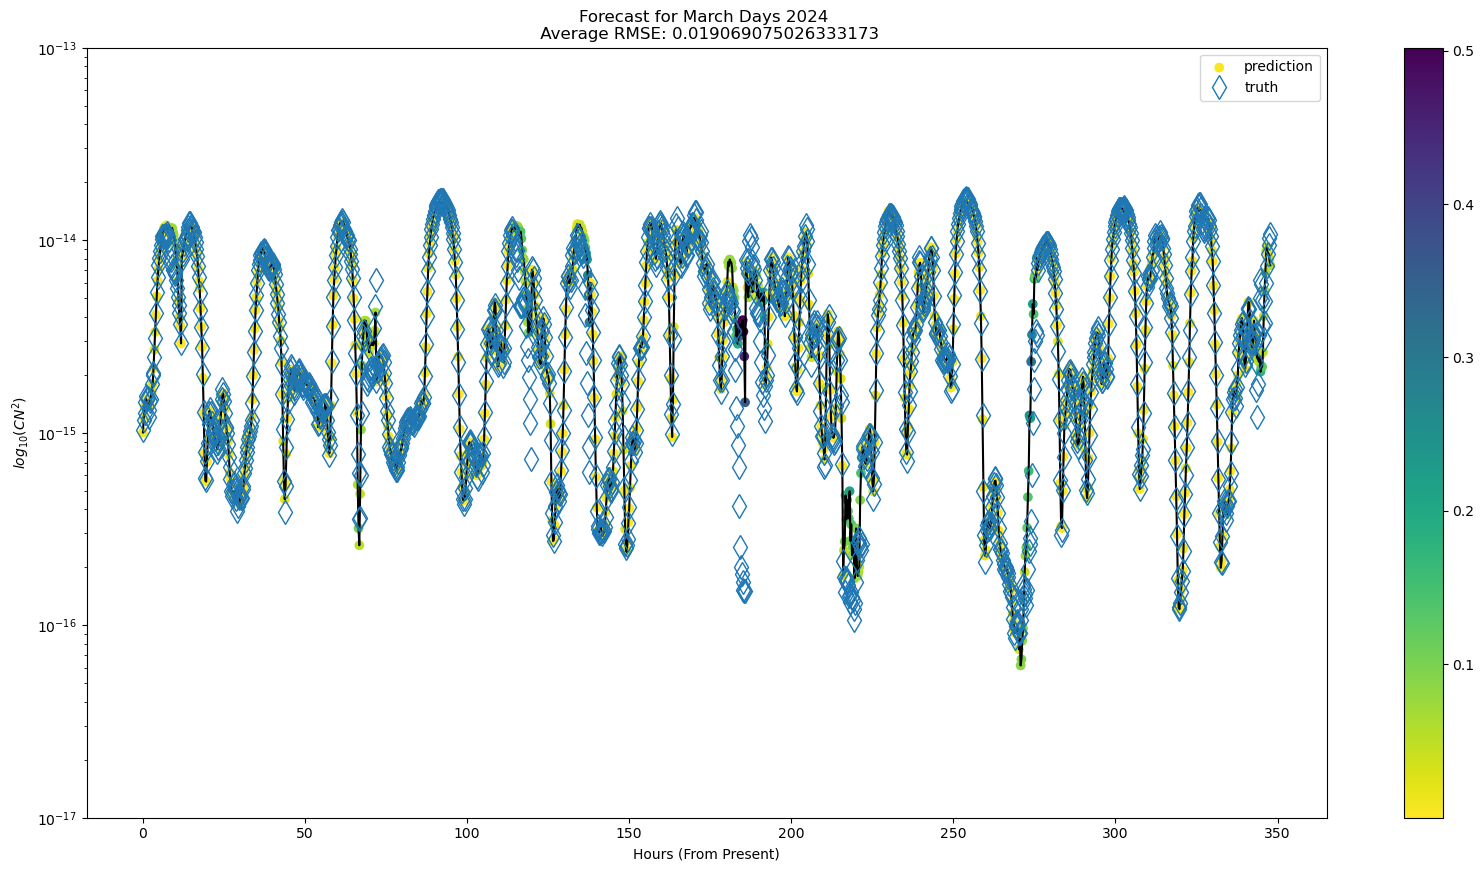

In [451]:
def min_to_hour(minute):
    return minute/60

hrs_2 = min_to_hour(np.arange(0,total_hours*15,15))
#hours = np.arange(total_hours)
y_CN2 = 10**(unnorm_data(y_total, minTrain[-1], maxTrain[-1]))

plt.figure(figsize=(20,10))
plt.scatter(hrs_2, total_forecasts, c = foxy, cmap='viridis_r', marker = 'o', label='prediction')
plt.plot(hrs_2, total_forecasts, color='black')
plt.plot(hrs_2, y_CN2, 'd', mfc='none', markersize=12, label='truth')
#plt.plot(hrs_2, truth[:output_len], color='blue')


plt.colorbar()
plt.ylabel(r'$log_{10}(CN^2)$')
plt.xlabel('Hours (From Present)')
plt.ylim(10**-17, 10**-13)
plt.yscale('log')
plt.title(f'Forecast for March Days 2024 \n Average RMSE: {np.mean(foxy)}')
plt.legend()